In [1]:

import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

import pandas as pd
import json
from datetime import datetime

import os
import shutil
from random import randint
import seaborn as sns
import warnings
from utils import generate_train_val_test_split, find_contours, generate_mask, write_dataset_to_directory
%matplotlib inline

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'



In [2]:
max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime)

'./dataframe_dumps\\df_eda_09-28-2023_10-07-41.json'

In [3]:
df = pd.read_json(max(glob("./dataframe_dumps/df_eda_*"), key=os.path.getmtime))

seed: 93
set
train    5506
val       987
test      928
Name: count, dtype: int64


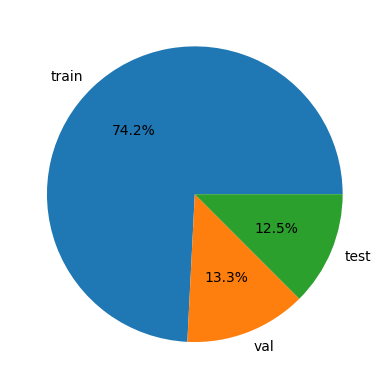

In [48]:
seed = randint(0, 100)
print(f"seed: {seed}")
df_split = generate_train_val_test_split(
    df=df, seed=seed, val_ratio=0.15, test_ratio=0.15
)
print(df_split[["path", "set"]].drop_duplicates()["set"].value_counts())
labels = df_split[["path", "set"]].drop_duplicates()["set"].value_counts().index
values = df_split[["path", "set"]].drop_duplicates()["set"].value_counts().values
_ = plt.pie(values, labels=labels, autopct="%.1f%%")

In [49]:
df_split[df_split["set"] == "train"].tag.unique()

array(['10_station_suelldorf_10.1', '11_main_station_11.1',
       '12_vegetation_steady_12.1', '13_station_ohlsdorf_13.1',
       '14_signals_station_14.2', '14_signals_station_14.3',
       '15_construction_vehicle_15.1', '17_signal_bridge_17.1',
       '19_vegetation_curve_19.1', '1_calibration_1.1',
       '20_vegetation_squirrel_20.1', '21_station_wedel_21.2',
       '21_station_wedel_21.3', '2_station_berliner_tor_2.1',
       '3_fire_site_3.1', '3_fire_site_3.2', '3_fire_site_3.4',
       '4_station_pedestrian_bridge_4.1',
       '4_station_pedestrian_bridge_4.3',
       '4_station_pedestrian_bridge_4.4', '5_station_bergedorf_5.1',
       '5_station_bergedorf_5.2', '6_station_klein_flottbek_6.1',
       '6_station_klein_flottbek_6.2',
       '7_approach_underground_station_7.1',
       '7_approach_underground_station_7.3', '8_station_altona_8.1',
       '8_station_altona_8.2', '9_station_ruebenkamp_9.3',
       '9_station_ruebenkamp_9.4', '9_station_ruebenkamp_9.5',
       '9_st

In [50]:
df_split[df_split["set"] == "test"].tag.unique()

array(['14_signals_station_14.1', '21_station_wedel_21.1',
       '4_station_pedestrian_bridge_4.2',
       '4_station_pedestrian_bridge_4.5',
       '7_approach_underground_station_7.2', '8_station_altona_8.3'],
      dtype=object)

In [51]:
df_split[df_split["set"] == "val"].tag.unique()

array(['16_under_bridge_16.1', '18_vegetation_switch_18.1',
       '1_calibration_1.2', '3_fire_site_3.3', '9_station_ruebenkamp_9.1',
       '9_station_ruebenkamp_9.2'], dtype=object)

## How to generate segments

10_station_suelldorf_10.1/rgb_highres_center/216_1631703820.700000022.png


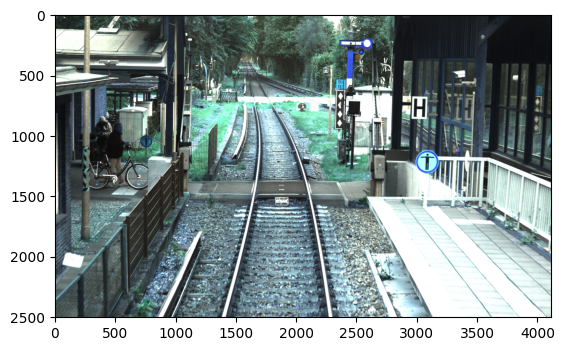

In [52]:
df_test = df_split[df_split["path"] == df_split["path"].values[10]]
print(df_test["path"].iloc[0])
img = cv2.imread(f"./orig_data/DB/{df_test['path'].iloc[0]}")
plt.imshow(img)

In [53]:
thickness = int(img.shape[1] / 100)

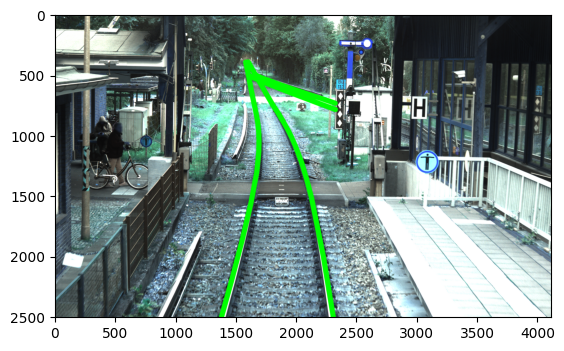

In [54]:
img_temp = img.copy()
for idx, row in df_test.iterrows():
    cv2.polylines(
        img_temp,
        np.int32([row["poly2d"]]),
        isClosed=row["closed"],
        color=(0, 255, 0),
        thickness=thickness,
    )
plt.imshow(img_temp)

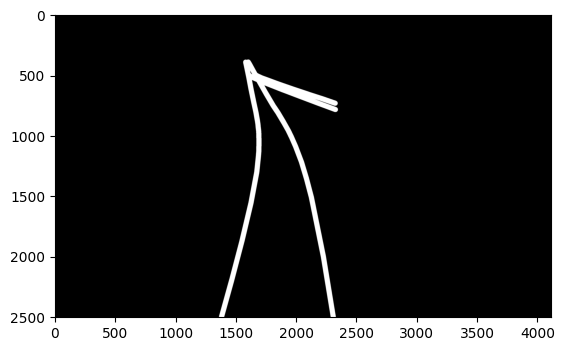

In [55]:
mask = np.zeros_like(img)
for idx, row in df_test.iterrows():
    cv2.polylines(
        mask,
        np.int32([row["poly2d"]]),
        isClosed=False,
        color=(255, 255, 255),
        thickness=thickness,
    )
plt.imshow(mask)

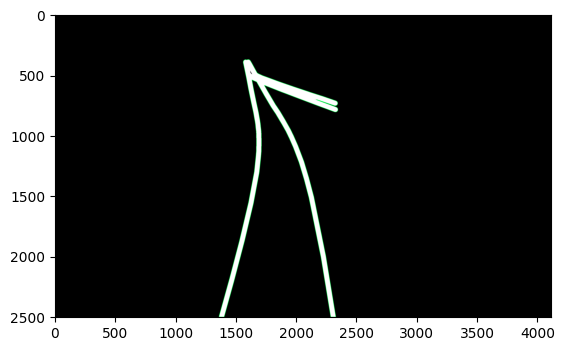

In [56]:
mask_temp = mask.copy()
imgray = cv2.cvtColor(mask_temp, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0.5, 1, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(
    thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
cv2.drawContours(mask_temp, contours, -1, (0, 255, 75), 2)
plt.imshow(mask_temp)

In [57]:
len(contours)

1

In [58]:
for c in contours:
    print(len(c))

5096


In [59]:
contours_small = []
for idx, contour in enumerate(contours):
    contour = np.append(contour, [contour[0]], axis=0)
    con_short = cv2.approxPolyDP(contour, epsilon=0.8, closed=True)
    points = [p for point in con_short for p in point[0]]
    points += [points[0], points[1]]
    contours_small.append(points)

In [60]:
for c in contours_small:
    print(len(c))

1296


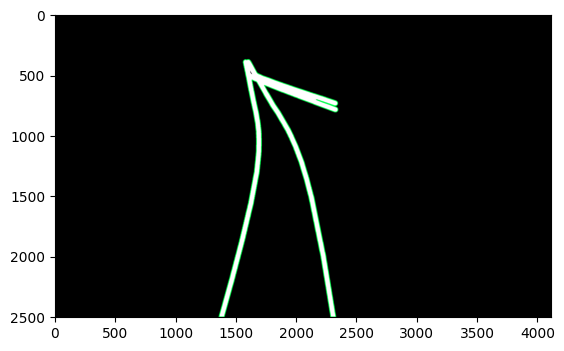

In [61]:
mask_temp = mask.copy()
cv2.drawContours(mask_temp, [con_short], -1, (0, 255, 75), 5)
plt.imshow(mask_temp)

## Foramlize ideas

In [62]:
df_test["path"].iloc[0]

'10_station_suelldorf_10.1/rgb_highres_center/216_1631703820.700000022.png'

In [63]:
mask = generate_mask(df, df_test["path"].iloc[0])

In [64]:
lables, coordinates = find_contours(mask)

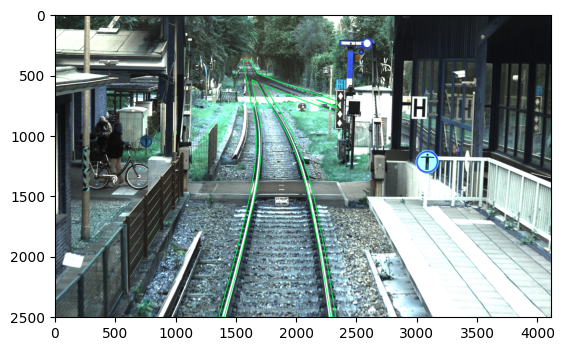

In [65]:
img_temp = img.copy()
for c in coordinates:
    cv2.drawContours(img_temp, [np.array(c)], -1, (0, 255, 75), 5)
plt.imshow(img_temp)

## Generate folder structure

In [66]:
df_split.to_csv(
    f"./dataframe_dumps/df_split_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.csv"
)

In [67]:
datasets = {}
datasets["data_all"] = df_split
datasets["data_ir"] = df_split[df_split["sensor"].str.contains("ir_")]
datasets["data_highres"] = df_split[df_split["sensor"].str.contains("rgb_highres")]
datasets["data_rgb"] = df_split[
    df_split["sensor"].str.contains("rgb_[clr]", regex=True)
]

C:\Users\atkovacs\AppData\Local\Temp\ipykernel_3588\3429196770.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


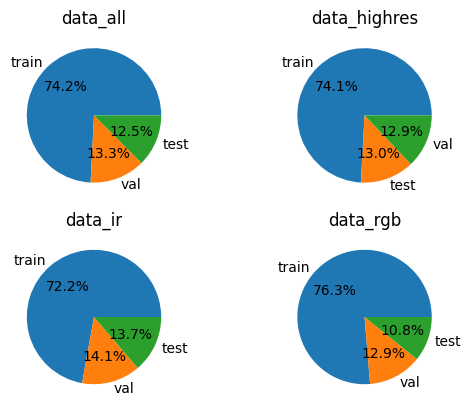

In [68]:
number_plots = len(datasets)
fig, ax = plt.subplots(2, 2)

for idx, (k, v) in enumerate(datasets.items()):
    labels = v[["path", "set"]].drop_duplicates()["set"].value_counts().index
    values = v[["path", "set"]].drop_duplicates()["set"].value_counts().values
    ax[idx % 2, idx // 2].pie(values, labels=labels, autopct="%.1f%%")
    ax[idx % 2, idx // 2].set_title(k)


fig.show()

In [69]:
path_data = "../rail_detection/datasets/"
path_yml = "../rail_detection/"
for k, v in datasets.items():
    write_dataset_to_directory(v, path_yml=path_yml, path_data=path_data, dataset=k)

## Test labeling

In [62]:
image = glob(f"{path_data}data_all/train/images/*")[0]
label = image.replace("png", "txt").replace("image", "label")

In [63]:
with open(label, "r") as f:
    labels = f.read().splitlines()

In [64]:
img = cv2.imread(image)
h, w = img.shape[:2]
h

480

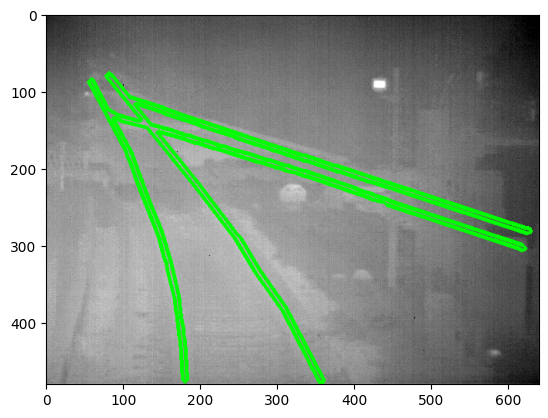

In [65]:
for label in labels:
    class_id, *poly = label.split(" ")

    poly = np.asarray(poly, dtype=np.float16).reshape(-1, 2)  # Read poly, reshape
    poly *= [w, h]  # Unscale

    cv2.polylines(img, [poly.astype("int")], True, (0, 255, 0), 4)  # Draw Poly Lines
    # cv2.fillPoly(img, [poly.astype('int')], (randint(0,255),randint(0,255),randint(0,255)), cv2.LINE_AA) # Draw area

    plt.imshow(img)